# Real-Time Bidding in Advertising

Contrary to sponsored advertising, where advertisers set fixed bids, in real-time bid‐ ding (RTB) you can set a bid for every individual impression. When a user visits a website that supports ads, this triggers an auction where advertisers bid for an impres‐ sion. Advertisers must submit bids within a period of time, where 100 ms is a com‐ mon limit.

The advertising platform provides contextual and behavioral information to the advertiser for evaluation. The advertiser uses an automated algorithm to decide how much to bid based upon the context. In the long-term, the platform’s products must deliver a satisfying experience, to maintain the advertising revenue stream. But adver‐ tisers want to maximize some key performance indicator (KPI), for example, the number of impressions or click through rate (CTR), for the least cost.

RTB presents a clear action (the bid), state (the information provided by the plat‐ form) and agent (the bidding algorithm). Both platforms and advertisers can use RL to optimize for their definition of reward.

To quickly demonstrate this idea, below I present some code to simulate a bidding environment. First let me install the dependencies.

## Setup

In [ ]:
!pip install pygame==1.9.6 pandas==1.0.5 matplotlib==3.2.1 gym==0.17.3 gym-display-advertising==0.0.1
!pip install --upgrade git+git://github.com/david-abel/simple_rl.git@77c0d6b910efbe8bdd5f4f87337c5bc4aed0d79c

In [ ]:
import numpy as np
import pandas as pd

from simple_rl.agents import RandomAgent, DelayedQAgent, DoubleQAgent, QLearningAgent

import gym
import gym_display_advertising

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("agg", force=True)

In [ ]:
%matplotlib inline

## Params

In [ ]:
eps = 0.05
gam = 0.99
alph = 0.0001
n_episodes = 200

## Utils

This section contains quite a lot of code. These are the helper functions to perform various aspects of the problem. For example, I need to discretize the state space so that it works with the tabular value-based algorithms.

Then there is some helper code to perform the training iteration. Loops in loops.

In [ ]:
def state_mapping(obs):
    """
    Since this is tabular, we can't use real numbers. There would be an infinite
    number of states. Instead I round and convert to an integer. This is a
    simple form of _tile coding_.
    """
    return tuple(np.round(100 * obs[0:1]))

def run_episode(env, agent, learning=True):
    episode_reward = 0
    observation = env.reset()
    episode_over = False
    reward = 0
    action_buffer = []
    while not episode_over:
        if hasattr(agent, "q_func"):
            action = agent.act(
                state_mapping(observation),
                reward,
                learning=learning)
        else:
            action = agent.act(
                state_mapping(observation),
                reward)
        action_buffer.append(observation[0])
        observation, reward, episode_over, _ = env.step(action)
        episode_reward += reward
    agent.end_of_episode()
    return episode_reward, action_buffer

def train_agent(env, agent_func, n_repeats):
    train_rewards_buffer = np.zeros((n_episodes, n_repeats))
    train_bid_buffer = np.zeros((n_episodes, n_repeats, env.batch_size))
    for instance in range(n_repeats):
        agent = agent_func(range(env.action_space.n))
        for episode in range(n_episodes):
            episode_reward, action_buffer = run_episode(env, agent)
            train_rewards_buffer[episode, instance] = episode_reward
            train_bid_buffer[episode, instance, :] = np.pad(
                action_buffer, (0, env.batch_size - len(action_buffer)),
                'constant', constant_values=0)

    if hasattr(agent, "q_func"):
        print_arbitrary_policy(agent.q_func)

    # Test
    agent.epsilon = 0
    episode_reward, test_bid_buffer = run_episode(env, agent, learning=False)
    print(
        "{}: {}".format(
            "TEST",
            episode_reward))
    print(train_rewards_buffer.transpose())
    print(test_bid_buffer)
    return train_rewards_buffer, train_bid_buffer.mean(axis=2)

In [ ]:
def average(data):
    return pd.DataFrame(data.mean(axis=1))

def save(df, path):
    df.to_json(path)

def print_arbitrary_policy(Q):
    for state in sorted(Q.keys(), key=lambda x: (x is None, x)):
        values = Q[state].items()
        print("{}: {}".format(state, sorted(values)))

## Agent

In [ ]:
def q_agent(actions):
    return QLearningAgent(
        actions,
        gamma=gam,
        epsilon=eps,
        alpha=alph,
    )

def random_agent(actions):
    return RandomAgent(actions)


def sarsa_agent(actions):
    return SARSAAgent(actions, 999, gamma=gam, epsilon=eps, alpha=alph, )

## Running the Experiment
Finally I’m going to run the experiments. I also print a lot of debugging so you can see the raw Q-values. I encourage you to inspect these, and investigate how this changes through learning.

In [ ]:
name = "bidding_rl_delta_q_learning"
env_name = "StaticDisplayAdvertising-v0"
num_repeats = 10
agent = q_agent
print("Starting {}".format(name))
env = gym.make(env_name)
rewards_buffer, bid_buffer = train_agent(env, agent, num_repeats)
save(average(rewards_buffer), name + ".json")
save(average(bid_buffer), name + "_bid.json")
print("Stopping {}".format(name))

Starting bidding_rl_delta_q_learning
(0.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0)]
(1.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0)]
(2.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0)]
(3.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0)]
(4.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0)]
(5.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 1.5986184241244227e-16)]
(6.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 2.9767579532479464e-17)]
(7.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 2.1017160764932272e-12)]
(8.0,): [(0, 0.0), (1, 2.937298888795957e-16), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0)]
(9.0,): [(0, 0.0), (1, 0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 7.863725940834891e-13), (6, 0)]
(10.0,): [(0, 0.0), (1, 0.0), (2, 7.683171571207736e-20), (3, 3.385530538584227e-13)

Next I run the same code again but this time with the random agent.

In [ ]:
name = "bidding_rl_delta_random"
env_name = "StaticDisplayAdvertising-v0"
num_repeats = 10
agent = random_agent
print("Starting {}".format(name))
env = gym.make(env_name)
rewards_buffer, bid_buffer = train_agent(env, agent, num_repeats)
save(average(rewards_buffer), name + ".json")
save(average(bid_buffer), name + "_bid.json")
print("Stopping {}".format(name))

Starting bidding_rl_delta_random
TEST: 1
[[ 0. 10.  4. ... 19. 51. 48.]
 [ 0.  0. 13. ... 19.  0.  2.]
 [ 0.  0.  0. ... 10. 12. 12.]
 ...
 [ 6.  1.  1. ... 35. 14.  3.]
 [ 6. 18. 12. ...  5. 25.  1.]
 [ 0.  0.  0. ... 16.  0.  1.]]
[0.28246021011155464, 0.26833719960597696, 0.13416859980298848, 0.1408770297931379, 0.1267893268138241, 0.13946825949520653, 0.1534150854447272, 0.0767075427223636, 0.0383537713611818, 0.0383537713611818, 0.04027145992924089, 0.04027145992924089, 0.04027145992924089, 0.020135729964620444, 0.02114251646285147, 0.010571258231425735, 0.005285629115712867, 0.0026428145578564336, 0.003964221836784651, 0.004360644020463115, 0.003924579618416804, 0.005886869427625206, 0.005592525956243945, 0.005592525956243945, 0.005872152254056143, 0.006459367479461757, 0.006782335853434846, 0.003391167926717423, 0.003221609530381552, 0.003221609530381552, 0.002899448577343397, 0.0014497242886716984, 0.0014497242886716984, 0.002174586433007548, 0.001957127789706793, 0.00097856389

## Results

In the next two plots I present the sum of the rewards in an episode, over 200 episode, averaged over 10 runs. You’d need to perform more averaging to the the plots smoother.

You can see that the RL based agent quickly learns where to position the bid amount in order to maximize the reward.

The second image shows the bid amount changes over time.

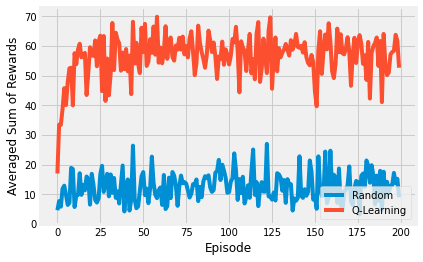

In [ ]:
data_files = [("Random", "bidding_rl_delta_random.json"),
              ("Q-Learning", "bidding_rl_delta_q_learning.json")]

fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Averaged Sum of Rewards')
ax.legend(loc='lower right')
plt.show()

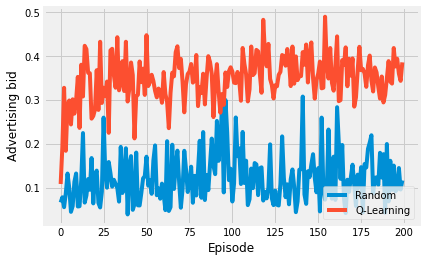

In [ ]:
data_files = [("Random", "bidding_rl_delta_random_bid.json"),
              ("Q-Learning", "bidding_rl_delta_q_learning_bid.json")]

fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Advertising bid')
ax.legend(loc='lower right')
plt.show()